In [1]:
import os
import sys
import time
import shutil
import pickle

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.metrics import f1_score
from tensorflow import keras
from tensorflow.keras import layers, models

import sklearn.preprocessing
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

2024-09-22 06:45:07.196597: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-22 06:45:07.257854: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-22 06:45:07.257895: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-22 06:45:07.260087: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-22 06:45:07.271587: I tensorflow/core/platform/cpu_feature_guar

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_virtual_device_configuration(
#                 gpu,
#                 [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])  # Set your memory limit here
#     except RuntimeError as e:
#         print(e)

1 Physical GPUs, 1 Logical GPUs


2024-09-22 06:45:10.972974: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-22 06:45:11.028101: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-22 06:45:11.028143: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-22 06:45:11.031379: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-22 06:45:11.031449: I external/local_xla/xla/stream_executor

In [3]:
def get_dataset(directory, single_file=False, use_half=False, section=1, use_num_files=False, num_files=100):  
    if single_file:
        df = pd.read_csv(directory, index_col='timestamp')
        df.dropna(inplace=True)
        return df
    
    merged_df = pd.DataFrame()
    list_files = os.listdir(directory)
    print(len(list_files))
    if use_num_files:
        for i in range(num_files):
            df = pd.read_csv(os.path.join(directory, list_files[i]), index_col='timestamp')
            df.dropna(inplace=True)
            merged_df = pd.concat([merged_df, df], ignore_index=True)

    if use_half:
        for i, files in enumerate(list_files):
            if section==1:
                if i > len(list_files) //2:
                    continue
                df = pd.read_csv(os.path.join(directory, files), index_col='timestamp')
                df.dropna(inplace=True)
                merged_df = pd.concat([merged_df, df], ignore_index=True)
            if section==2:
                if i <= len(list_files) // 2:
                    continue
                df = pd.read_csv(os.path.join(directory, files), index_col='timestamp')
                df.dropna(inplace=True)
                merged_df = pd.concat([merged_df, df], ignore_index=True)
    else:
        for files in list_files:
            df = pd.read_csv(os.path.join(directory, files), index_col='timestamp')
            df.dropna(inplace=True)
            merged_df = pd.concat([merged_df, df], ignore_index=True)
    
    # print(i)
    return merged_df

In [4]:
def convert_time_window(data, timesteps):
    samples = data.shape[0] - timesteps + 1  # Number of samples in the new 3D array
    variables = data.shape[1]  # Number of variables (features)

    data_3d = np.zeros((samples, timesteps, variables), dtype='float32')

    for i in range(samples):
        data_3d[i] = data[i:i+timesteps]
    return data_3d

In [5]:
def inverse_convert_time_window(data_3d):
    samples, timesteps, variables = data_3d.shape
    data_2d = np.zeros((samples + timesteps - 1, variables))

    count = np.zeros((samples + timesteps - 1, variables))

    for i in range(samples):
        data_2d[i:i+timesteps] += data_3d[i]
        count[i:i+timesteps] += 1

    # Average the overlapping segments
    data_2d /= count
    return data_2d

In [6]:
def calculate_reconstruction_loss(data, reconstructions):
    reconstruction_errors = np.mean(np.square(data - reconstructions), axis=1)
    return reconstruction_errors

In [7]:
def find_optimal_threshold(reconstruction_errors, y_true):
    from sklearn.metrics import accuracy_score, balanced_accuracy_score

    best_threshold = 0.0
    best_f1 = 0.0
    best_y_pred = np.zeros(reconstruction_errors.shape)
    # q3 = np.percentile(reconstruction_errors, 75)
    # q1 = np.percentile(reconstruction_errors, 25)
    # iqr = q3 - q1
    upper_bound = np.max(reconstruction_errors)
    lower_bound = np.min(reconstruction_errors)

    thresholds = np.linspace(lower_bound, upper_bound, num=500)

    for threshold in thresholds:
        y_pred = np.where((reconstruction_errors > threshold) ,1, 0)
        # print(y_pred.shape)
        # print(y_true.shape)

        # Hitung F1-Score
        current_f1 = balanced_accuracy_score(y_true.astype(bool), y_pred.astype(bool))

        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = threshold
            best_y_pred = y_pred

    return best_threshold, best_f1, best_y_pred

In [8]:
# def find_optimal_threshold(reconstruction_errors, y_true):
#     from sklearn.metrics import accuracy_score, balanced_accuracy_score

#     best_threshold = 0.0
#     best_f1 = 0.0
#     best_y_pred = np.zeros(reconstruction_errors.shape)
#     q3 = np.percentile(reconstruction_errors, 75)
#     q1 = np.percentile(reconstruction_errors, 25)
#     iqr = q3 - q1
#     upper_bound = max(np.max(reconstruction_errors) / 2, (q3 + iqr * 1.5))
#     lower_bound = min(np.min(reconstruction_errors) / 2, (q1 - iqr * 1.5))

#     thresholds = np.linspace(lower_bound, upper_bound, num=500)

#     for threshold in thresholds:
#         y_pred = np.where(
#             (reconstruction_errors > (threshold + iqr)) | 
#             (reconstruction_errors < (threshold - iqr)),
#               1, 0)
#         # print(y_pred.shape)
#         # print(y_true.shape)

#         # Hitung F1-Score
#         current_f1 = balanced_accuracy_score(y_true.astype(bool), y_pred.astype(bool))

#         if current_f1 > best_f1:
#             best_f1 = current_f1
#             best_threshold = threshold
#             best_y_pred = y_pred

#     return best_threshold, best_f1, best_y_pred

## Training

In [9]:
merged_df = pd.read_csv("../../filtered_dataset/train/selected_instance_2.csv", index_col='timestamp')

In [10]:
# merged_df = get_dataset('../../datasets/3W/dataset_processed/splitted/0/train')
merged_data_class = merged_df['class']

merged_data_np = merged_df.drop('class', axis=1).values

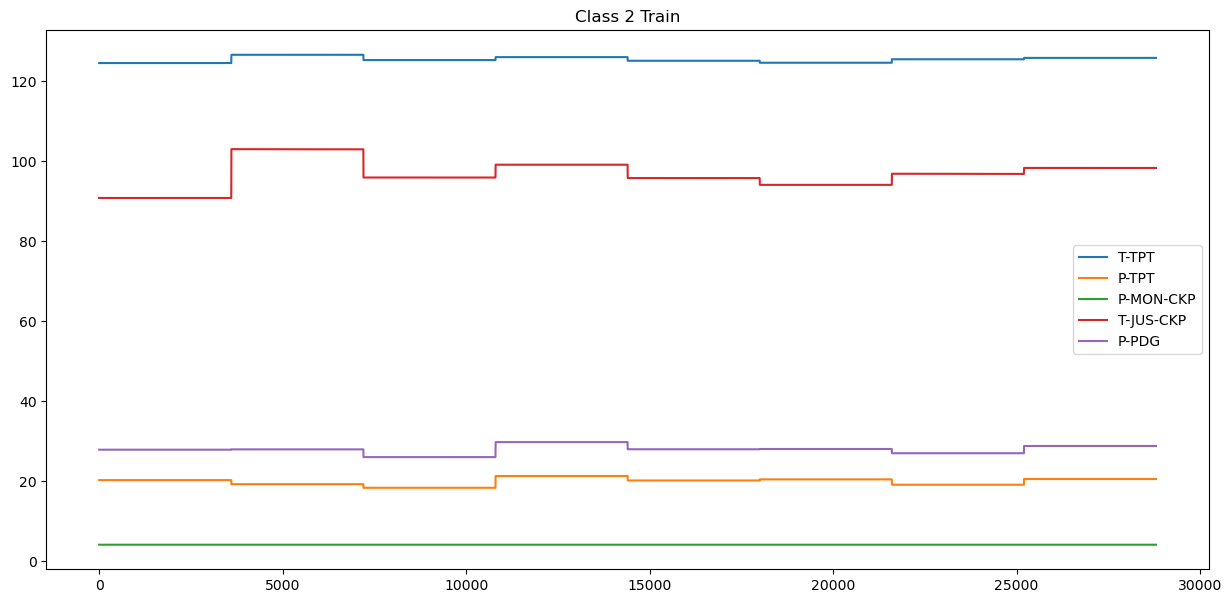

In [11]:
plt.figure(figsize=(15,7))
plt.plot(merged_data_np)
plt.legend(['T-TPT','P-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-PDG'])
plt.title("Class 2 Train")
plt.show()

In [12]:
# merged_data_np_3d = convert_time_window(merged_data_np_scaled, 10)
merged_data_np_3d = convert_time_window(merged_data_np, 10)

In [13]:
merged_data_np_3d.dtype

dtype('float32')

In [14]:
merged_data_np_3d.shape

(28791, 10, 5)

In [ ]:
tf_dataset_path = "../../datasets/3W/dataset_processed/tf_data/LSTM-GAN/train-filtered/2"

dataset = tf.data.Dataset.from_tensor_slices(merged_data_np_3d)
dataset = dataset.batch(64)
tf.data.Dataset.save(dataset, tf_dataset_path)

### ==================================================

In [9]:
# To use available dataset
tf_dataset_path = "../../datasets/3W/dataset_processed/tf_data/LSTM-GAN/train-filtered/2"
dataset = tf.data.Dataset.load(tf_dataset_path)

In [8]:
def build_encoder(input_shape):
    input_layer = layers.Input(shape=input_shape)
    encoder = layers.LSTM(128, return_sequences=True)(input_layer)
    encoder = layers.LSTM(64, return_sequences=True)(encoder)
    encoder = layers.LSTM(32)(encoder)
    encoder = layers.Dense(24, activation='relu')(encoder)
    output_layer = layers.Dense(10, activation='relu')(encoder)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer, name="Encoder")    
    return model

def build_decoder(output_shape):
    input_layer = layers.Input(shape=(10,))
    decoder = layers.Dense(24, activation='relu')(input_layer)
    decoder = layers.Dense(24, activation='relu')(decoder)
    decoder = layers.RepeatVector(output_shape[0])(decoder)

    decoder = layers.LSTM(32, return_sequences=True)(decoder)
    decoder = layers.LSTM(64, return_sequences=True)(decoder)
    decoder = layers.LSTM(128, return_sequences=True)(decoder)

    output_layer = layers.TimeDistributed(layers.Dense(output_shape[1]))(decoder)
    model = keras.models.Model(inputs=input_layer, outputs=output_layer, name="Decoder")
    
    return model

def build_discriminator(input_shape):
    input_layer = layers.Input(shape=input_shape)
    encoder = layers.LSTM(128, return_sequences=True)(input_layer)
    encoder = layers.LSTM(64, return_sequences=True)(encoder)
    encoder = layers.LSTM(32)(encoder)
    encoder = layers.Dense(24, activation='relu')(encoder)
    encoder = layers.Dense(10, activation='relu')(encoder)
    output_layer = layers.Dense(1, activation='sigmoid')(encoder)
    
    model = keras.models.Model(inputs=input_layer, outputs=output_layer, name="Discriminator")

    return model

In [9]:
class Generator(models.Model):
    def __init__(self, input_shape, output_shape):
        super(Generator, self).__init__()
        self.encoder = build_encoder(input_shape)
        self.decoder = build_decoder(output_shape)

    def call(self, x):
        z = self.encoder(x)
        reconstructed_x = self.decoder(z)
        return reconstructed_x


In [10]:
# L1 norm for lx
def reconstruction_loss_lx(x, generated_x):
    return tf.reduce_mean(tf.abs(x - generated_x))

# L2 norm for lz
def reconstruction_loss_lz(z_enc1, z_enc2):
    return tf.reduce_mean(tf.square(z_enc1 - z_enc2))

# Adversarial loss for generator
def adversarial_loss(disc_output_gen):
    return tf.keras.losses.BinaryCrossentropy()(tf.ones_like(disc_output_gen), disc_output_gen)

# Total Generator loss
def generator_loss(x, generated_x, z_enc1, z_enc2, disc_output_gen, w1, w2, w3):
    x = tf.cast(x, tf.float16)
    generated_x = tf.cast(generated_x, tf.float16)
    z_enc1 = tf.cast(z_enc1, tf.float16)
    z_enc2 = tf.cast(z_enc2, tf.float16)
    disc_output_gen = tf.cast(disc_output_gen, tf.float16)

    lx = reconstruction_loss_lx(x, generated_x)
    lz = reconstruction_loss_lz(z_enc1, z_enc2)
    ladv = adversarial_loss(disc_output_gen)
    return w1 * lx + w2 * lz + w3 * ladv

# Discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

In [11]:
# Define the input shape
time_window = 10 
features = 5  
input_shape = (time_window, features)

# Define optimizers
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)

In [14]:
# Instantiate models
generator = Generator(input_shape, input_shape)
discriminator = build_discriminator(input_shape)
encoder2 = build_encoder(input_shape)

# Example of compiling the discriminator
discriminator.compile(optimizer=disc_optimizer, loss='binary_crossentropy')
# generator.encoder.compile(optimizer=gen_optimizer, loss=generator_loss)


2024-09-21 21:47:50.290537: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [15]:
generator.encoder.summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 5)]           0         
                                                                 
 lstm (LSTM)                 (None, 10, 128)           68608     
                                                                 
 lstm_1 (LSTM)               (None, 10, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
 dense_1 (Dense)             (None, 10)                250       
                                                                 
Total params: 131474 (513.57 KB)
Trainable params: 131474 (

In [16]:
generator.decoder.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_2 (Dense)             (None, 24)                264       
                                                                 
 dense_3 (Dense)             (None, 24)                600       
                                                                 
 repeat_vector (RepeatVecto  (None, 10, 24)            0         
 r)                                                              
                                                                 
 lstm_3 (LSTM)               (None, 10, 32)            7296      
                                                                 
 lstm_4 (LSTM)               (None, 10, 64)            24832     
                                                           

In [17]:
encoder2.summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 10, 5)]           0         
                                                                 
 lstm_9 (LSTM)               (None, 10, 128)           68608     
                                                                 
 lstm_10 (LSTM)              (None, 10, 64)            49408     
                                                                 
 lstm_11 (LSTM)              (None, 32)                12416     
                                                                 
 dense_8 (Dense)             (None, 24)                792       
                                                                 
 dense_9 (Dense)             (None, 10)                250       
                                                                 
Total params: 131474 (513.57 KB)
Trainable params: 131474 (

In [18]:
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10, 5)]           0         
                                                                 
 lstm_6 (LSTM)               (None, 10, 128)           68608     
                                                                 
 lstm_7 (LSTM)               (None, 10, 64)            49408     
                                                                 
 lstm_8 (LSTM)               (None, 32)                12416     
                                                                 
 dense_5 (Dense)             (None, 24)                792       
                                                                 
 dense_6 (Dense)             (None, 10)                250       
                                                                 
 dense_7 (Dense)             (None, 1)               

In [14]:
# Use when retraining existing models
generator = Generator(input_shape, input_shape)
generator.encoder = tf.keras.models.load_model("../../models/3W/LSTM-GAN/train-filtered/0/generator-encoder-21-9-2024.h5")
generator.decoder = tf.keras.models.load_model("../../models/3W/LSTM-GAN/train-filtered/0/generator-decoder-21-9-2024.h5")

encoder2 = tf.keras.models.load_model("../../models/3W/LSTM-GAN/train-filtered/0/encoder2-21-9-2024.h5")
discriminator = tf.keras.models.load_model("../../models/3W/LSTM-GAN/train-filtered/0/discriminator-21-9-2024.h5")

2024-09-22 05:09:21.783225: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [15]:
generator.encoder.summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 5)]           0         
                                                                 
 lstm (LSTM)                 (None, 10, 128)           68608     
                                                                 
 lstm_1 (LSTM)               (None, 10, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
 dense_1 (Dense)             (None, 10)                250       
                                                                 
Total params: 131474 (513.57 KB)
Trainable params: 131474 (

In [16]:
# Prefetch for performance optimization
data_loader = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [16]:
# def generate_random_noise(batch_size, time_window, features):
#     return tf.random.normal(shape=(batch_size, time_window, features))

In [17]:
import warnings
warnings.filterwarnings('ignore')

epochs = 20  # Example number of epochs
w1 = 0.2
w2 = 0.3
w3 = 0.5
# batch_size = 128

for epoch in range(epochs):
    gen_loss_total = 0
    disc_loss_total = 0
    num_batches = 0
    
    for batch in data_loader:
        batch_size = np.array(batch).shape[0]  
        # print("Generate random noise...")
        # z = generate_random_noise(batch_size, time_window, features) 
        # z = np.float16(z)
        num_batches += 1
        
        # Train discriminator
        with tf.GradientTape() as disc_tape:
            real_output = discriminator(np.array(batch))  # Discriminator evaluates real data
            generated_x = generator(np.array(batch))
            fake_output = discriminator(generated_x)  # Discriminator evaluates generated data
            disc_loss = discriminator_loss(real_output, fake_output)
        
        # print("Discriminator train...")
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
        # Train generator
        with tf.GradientTape() as gen_tape:
            generated_x = generator(np.array(batch))          # Generator produces data from noise
            fake_output_gen = discriminator(generated_x)  # Discriminator evaluates generated data
            
            # Since we're training the generator, we compare the generated data against real data
            z_enc1 = generator.encoder(np.array(batch))  # Encoder1 with real data
            z_enc2 = encoder2(generated_x)     # Encoder2 with generated data
            
            gen_loss = generator_loss(batch, generated_x, z_enc1, z_enc2, fake_output_gen, w1, w2, w3)
        
        if np.isnan(gen_loss.numpy()) & np.isnan(disc_loss.numpy()):
            print(f"[{num_batches}]: GENERATOR LOSS AND DISCRIMINATOR LOSS BECOME NaN. End train process...")
            break
        # print("Generator train...")
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        
        gen_loss_total += gen_loss.numpy()
        disc_loss_total += disc_loss.numpy()

        if num_batches % 100 == 0:
            print(f'[{num_batches}]: \tloss_g: {gen_loss}, loss_d: {disc_loss}')
            generator.encoder.save(f"../../models/3W/LSTM-GAN/train-filtered/2/generator-encoder-22-9-2024_E{epoch+1}.h5")
            generator.decoder.save(f"../../models/3W/LSTM-GAN/train-filtered/2/generator-decoder-22-9-2024_E{epoch+1}.h5")
            encoder2.save(f"../../models/3W/LSTM-GAN/train-filtered/2/encoder2-22-9-2024_E{epoch+1}.h5")
            discriminator.save(f"../../models/3W/LSTM-GAN/train-filtered/2/discriminator-22-9-2024_E{epoch+1}.h5")
    
    avg_gen_loss = gen_loss_total / num_batches
    avg_disc_loss = disc_loss_total / num_batches
    
    # Log the losses
    print(f'Epoch {epoch+1}/{epochs}, Generator Loss: {avg_gen_loss}, Discriminator Loss: {avg_disc_loss}')
    # save each model
    if  ~np.isnan(gen_loss.numpy()) & ~np.isnan(disc_loss.numpy()):
        print("Save models")
        generator.encoder.save("../../models/3W/LSTM-GAN/train-filtered/2/generator-encoder-22-9-2024.h5")
        generator.decoder.save("../../models/3W/LSTM-GAN/train-filtered/2/generator-decoder-22-9-2024.h5")
        encoder2.save("../../models/3W/LSTM-GAN/train-filtered/2/encoder2-22-9-2024.h5")
        discriminator.save("../../models/3W/LSTM-GAN/train-filtered/2/discriminator-22-9-2024.h5")


2024-09-22 05:09:34.985892: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-09-22 05:09:35.723710: I external/local_xla/xla/service/service.cc:168] XLA service 0x560fb83532e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-22 05:09:35.723763: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA T500, Compute Capability 7.5
2024-09-22 05:09:35.729008: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1726956575.808246  458073 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


[100]: 	loss_g: 4.55859375, loss_d: 5.042631149291992
[200]: 	loss_g: 4.23046875, loss_d: 5.021048545837402
[300]: 	loss_g: 3.77734375, loss_d: 4.984289646148682
[400]: 	loss_g: 3.802734375, loss_d: 4.891674518585205
Epoch 1/20, Generator Loss: 4.076779513888889, Discriminator Loss: 4.988721787134806
Save models
[100]: 	loss_g: 3.68359375, loss_d: 4.605503559112549
[200]: 	loss_g: 3.30859375, loss_d: 4.543989658355713
[300]: 	loss_g: 2.9375, loss_d: 4.395927429199219
[400]: 	loss_g: 2.94921875, loss_d: 4.253399848937988
Epoch 2/20, Generator Loss: 3.1950477430555555, Discriminator Loss: 4.477116323047214
Save models
[100]: 	loss_g: 2.9296875, loss_d: 3.979779005050659
[200]: 	loss_g: 2.5390625, loss_d: 3.8286092281341553
[300]: 	loss_g: 2.119140625, loss_d: 3.6103005409240723
[400]: 	loss_g: 2.203125, loss_d: 3.495218515396118
Epoch 3/20, Generator Loss: 2.4248394097222223, Discriminator Loss: 3.7623859368430246
Save models
[100]: 	loss_g: 2.259765625, loss_d: 3.3391706943511963
[200]:

In [29]:
# generator.encoder.save("../../models/3W/LSTM-GAN/generator-encoder-v1.h5")
# generator.decoder.save("../../models/3W/LSTM-GAN/generator-decoder-v1.h5")
# encoder2.save("../../models/3W/LSTM-GAN/encoder2-v1.h5")
# discriminator.save("../../models/3W/LSTM-GAN/discriminator-v1.h5")

In [16]:
ttt = [np.array(batch).shape for batch in data_loader]
print(len(ttt))

4720


In [17]:
# Sample dataset and training example
# train_data = merged_data_np_3d
# train_dataset = tf.data.Dataset.from_tensor_slices(train_data).batch(32)

## Testing

In [13]:
dataset_dir = "../../datasets/3W/dataset/2"
list_files = ["SIMULATED_00001.parquet","SIMULATED_00002.parquet","SIMULATED_00003.parquet"]

merged_df_test = pd.DataFrame(columns=['T-TPT','P-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-PDG', 'class'])
for files in list_files:
    df = pd.read_parquet(os.path.join(dataset_dir, files))
    df = df[['T-TPT','P-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-PDG', 'class']]
    merged_df_test = pd.concat([merged_df_test, df])
# merged_df_test = pd.read_parquet(dataset_dir)
# merged_df_test = merged_df_test[['T-TPT','P-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-PDG', 'class']]

# Scale pressure columns (those starting with 'P') by 10^6
pressure_columns = [col for col in merged_df_test.columns if col.startswith('P')]
merged_df_test[pressure_columns] = merged_df_test[pressure_columns] / 10**6   

# dataset_dir = "../../datasets/3W/dataset_processed/splitted/2/test"

# list_files = os.listdir(dataset_dir)
# file_count = 4

# merged_df_test = pd.DataFrame(columns=['C1','C2','C3','class'])

# for i in range(file_count):
#     df = pd.read_csv(os.path.join(dataset_dir, list_files[i]), index_col='timestamp')
#     df.columns = ['C1','C2','C3','class']
#     merged_df_test = pd.concat([merged_df_test, df], ignore_index=True)

/tmp/ipykernel_475204/3551681881.py:8: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  merged_df_test = pd.concat([merged_df_test, df])
/tmp/ipykernel_475204/3551681881.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  merged_df_test = pd.concat([merged_df_test, df])


In [14]:
merged_data_test_class = merged_df_test['class']

merged_data_test_np = merged_df_test.drop('class', axis=1).values

In [15]:
# scaler_test = pickle.load(open('StandardScaler-3W-2.pkl', 'rb'))
# merged_data_test_np_scaled = scaler_test.transform(merged_data_test_np)
merged_data_test_np_3d = convert_time_window(merged_data_test_np, 10)

In [16]:
merged_data_test_np_3d.shape

(86388, 10, 5)

In [12]:
generator_encoder = tf.keras.models.load_model("../../models/3W/LSTM-GAN/train-filtered/2/generator-encoder-22-9-2024.h5")
generator_decoder = tf.keras.models.load_model("../../models/3W/LSTM-GAN/train-filtered/2/generator-decoder-22-9-2024.h5")

2024-09-22 06:45:50.946791: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [18]:
with tf.device('/CPU:0'):
    Z_test = generator_encoder(merged_data_test_np_3d)
# pred_3d_np = generator_decoder(Z_test).numpy()

In [19]:
with tf.device('/CPU:0'):
    pred_3d_np = generator_decoder(Z_test)

In [20]:
pred_2d = inverse_convert_time_window(pred_3d_np.numpy())
# pred_2d_inv = scaler_test.inverse_transform(pred_2d)

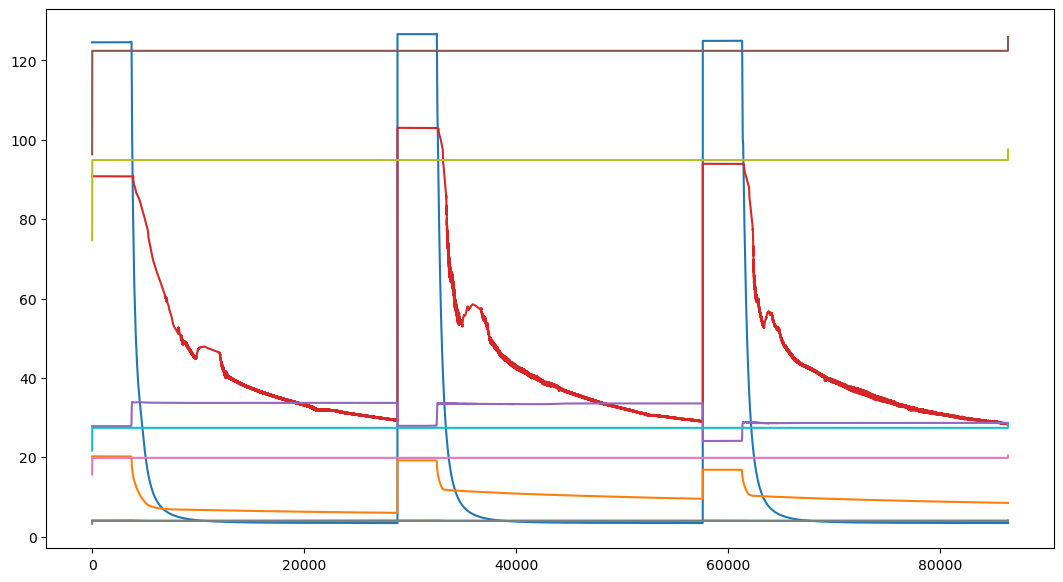

In [21]:
plt.figure(figsize=(13,7))
plt.plot(merged_data_test_np)
plt.plot(pred_2d)
# plt.legend(['C1','C2','C3','C1-rec','C2-rec','C3-rec',])
plt.show()

In [22]:
r_e = calculate_reconstruction_loss(merged_data_test_np, pred_2d)

In [23]:
thres, f1, y_pred = find_optimal_threshold((r_e), np.array(merged_data_test_class))
print(thres, f1)

19.880354033416054 0.9971692053476549


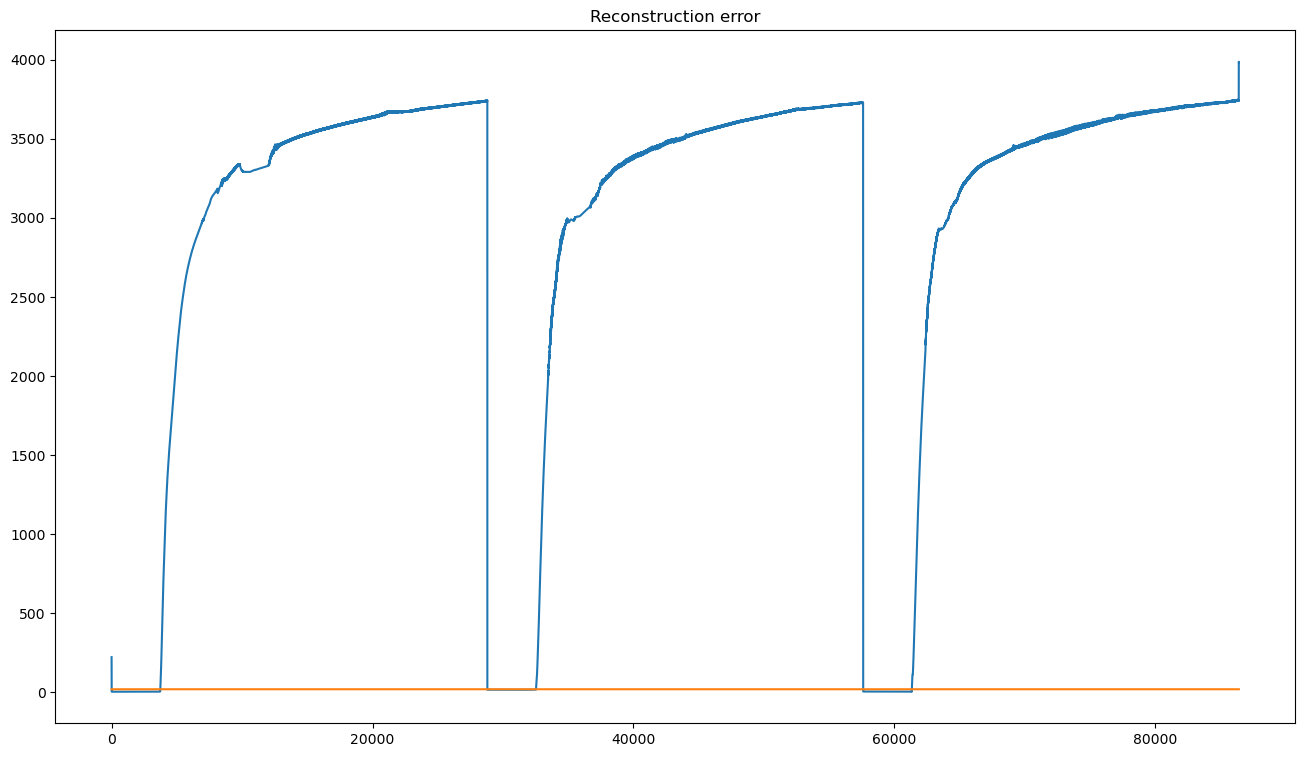

In [24]:
# iqr = np.percentile(r_e, 75) - np.percentile(r_e, 25)

plt.figure(figsize=(16,9))
plt.plot(r_e)
plt.plot(np.full(r_e.shape[0], thres))
# xmin, xmax, ymin, ymax = plt.axis()
# plt.fill_betweenx(np.linspace(thres-iqr, thres+iqr, 100), r_e.shape[0], color='blue', alpha=0.3)
plt.title("Reconstruction error")
plt.show()

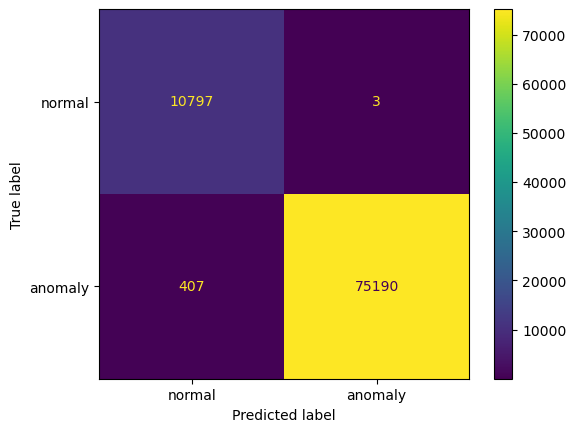

In [25]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(np.array(merged_data_test_class).astype(bool), y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['normal', 'anomaly'])
cm_display.plot()

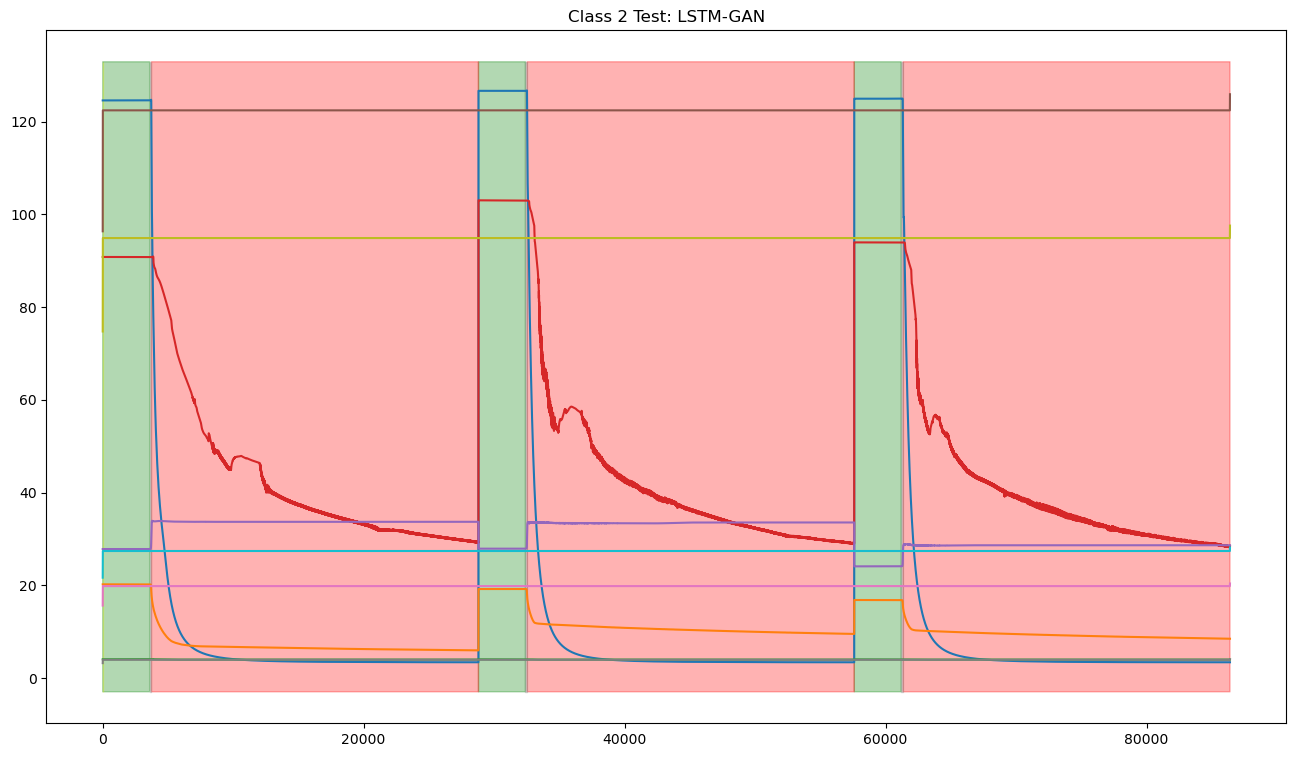

In [26]:
plt.figure(figsize=(16,9))
plt.plot(merged_data_test_np)
plt.plot(pred_2d)
xmin, xmax, ymin, ymax = plt.axis()
plt.fill_between(np.arange(0,len(pred_2d)), ymax, ymin, where=((~merged_data_test_class.astype(bool)) & (~y_pred)), color='green', alpha=0.3)
plt.fill_between(np.arange(0,len(pred_2d)), ymax, ymin,where=((merged_data_test_class.astype(bool)) & (y_pred)), color='red', alpha=0.3)
plt.fill_between(np.arange(0,len(pred_2d)), ymax, ymin,where=(~merged_data_test_class.astype(bool) & y_pred ), color='yellow', alpha=0.3)
plt.fill_between(np.arange(0,len(pred_2d)), ymax, ymin,where=(merged_data_test_class.astype(bool) & ~y_pred ), color='gray', alpha=0.3)
# plt.legend(['P-PDG','P-TPT', 'T-TPT','P-PDG_rec','P-TPT_rec', 'T-TPT_rec','normal','anomaly','missclasiffied (FP)','missclasiffied (FN)'])
plt.title("Class 2 Test: LSTM-GAN")
plt.show()

### Smaller sample size testing

In [13]:
sample_test = pd.read_parquet("../../datasets/3W/dataset/8/SIMULATED_00001.parquet")
sample_test = sample_test[['T-TPT','P-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-PDG', 'class']]

# Scale pressure columns (those starting with 'P') by 10^6
pressure_columns = [col for col in sample_test.columns if col.startswith('P')]
sample_test[pressure_columns] = sample_test[pressure_columns] / 10**6   

# sample_test = pd.read_csv('../../datasets/3W/dataset_processed/csv/2/WELL-00011_20141006150121.csv', index_col='timestamp')
# sample_test.dropna(inplace=True)
sample_test['class'].fillna(value=0, inplace=True) 
sample_test_class = sample_test['class']
sample_test_np = sample_test.drop('class',axis=1).values

<Axes: xlabel='timestamp'>

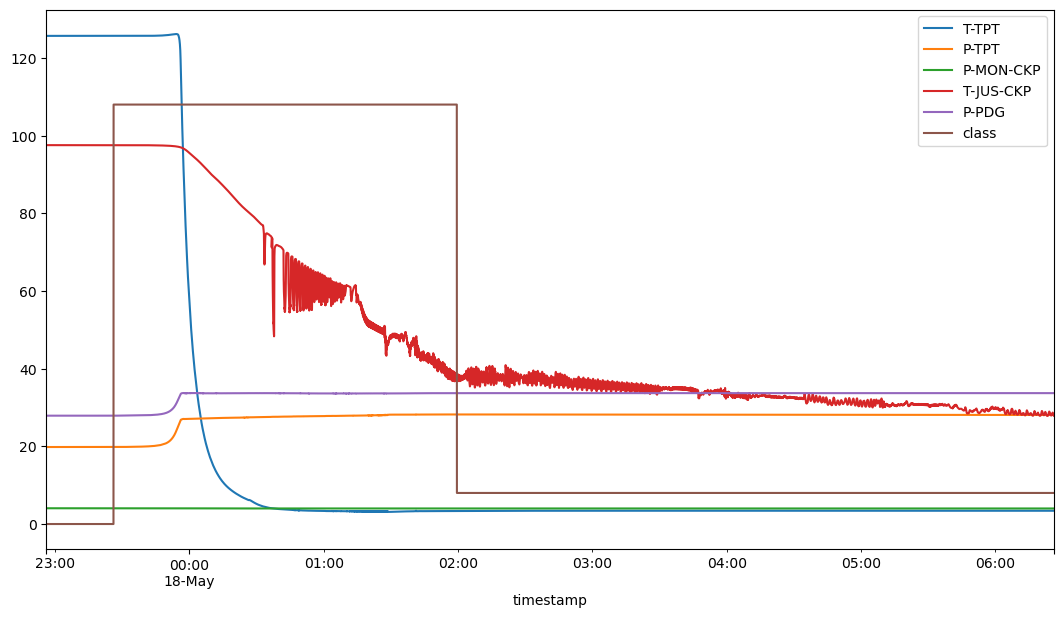

In [14]:
sample_test.plot(figsize=(13,7))

In [15]:
# scaler_test = pickle.load(open('StandardScaler-3W-2.pkl', 'rb'))
# sample_test_np_scaled = scaler_test.transform(sample_test_np)
sample_test_np_3d = convert_time_window(sample_test_np, 10)

In [16]:
Z_test = generator_encoder(sample_test_np_3d)
pred_3d_np = generator_decoder(Z_test).numpy()

2024-09-22 06:46:20.304831: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-09-22 06:46:20.319891: W external/local_tsl/tsl/framework/bfc_allocator.cc:366] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


In [17]:
pred_2d = inverse_convert_time_window(pred_3d_np)

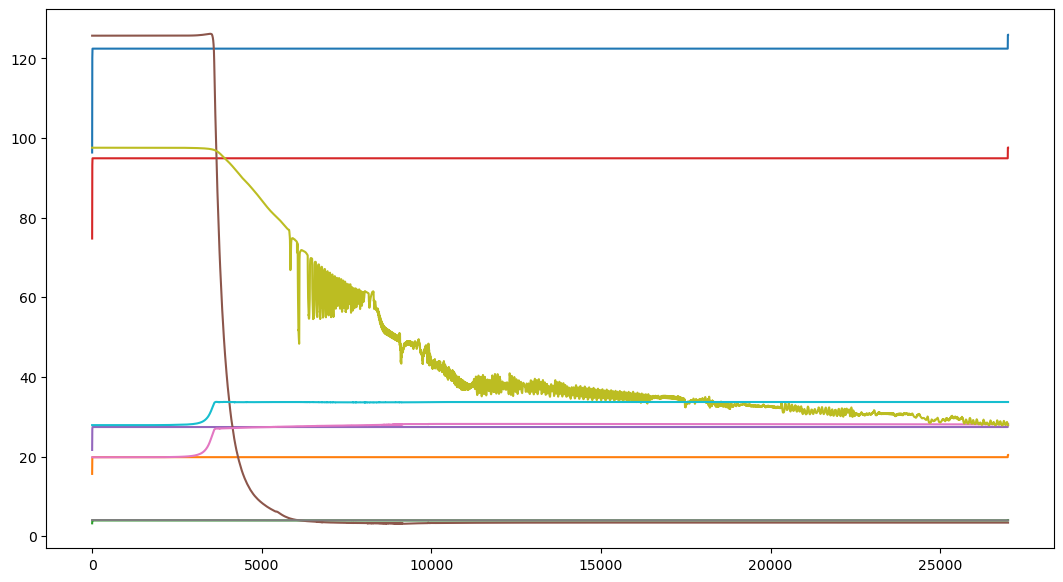

In [18]:
plt.figure(figsize=(13,7))
plt.plot(pred_2d)
plt.plot(sample_test_np)
plt.show()

In [19]:
r_e = calculate_reconstruction_loss(sample_test_np, pred_2d)

In [20]:
thres, f1, sample_y_pred  = find_optimal_threshold(r_e, sample_test_class)
print(thres, f1)

11.559209960109744 0.964720877371677


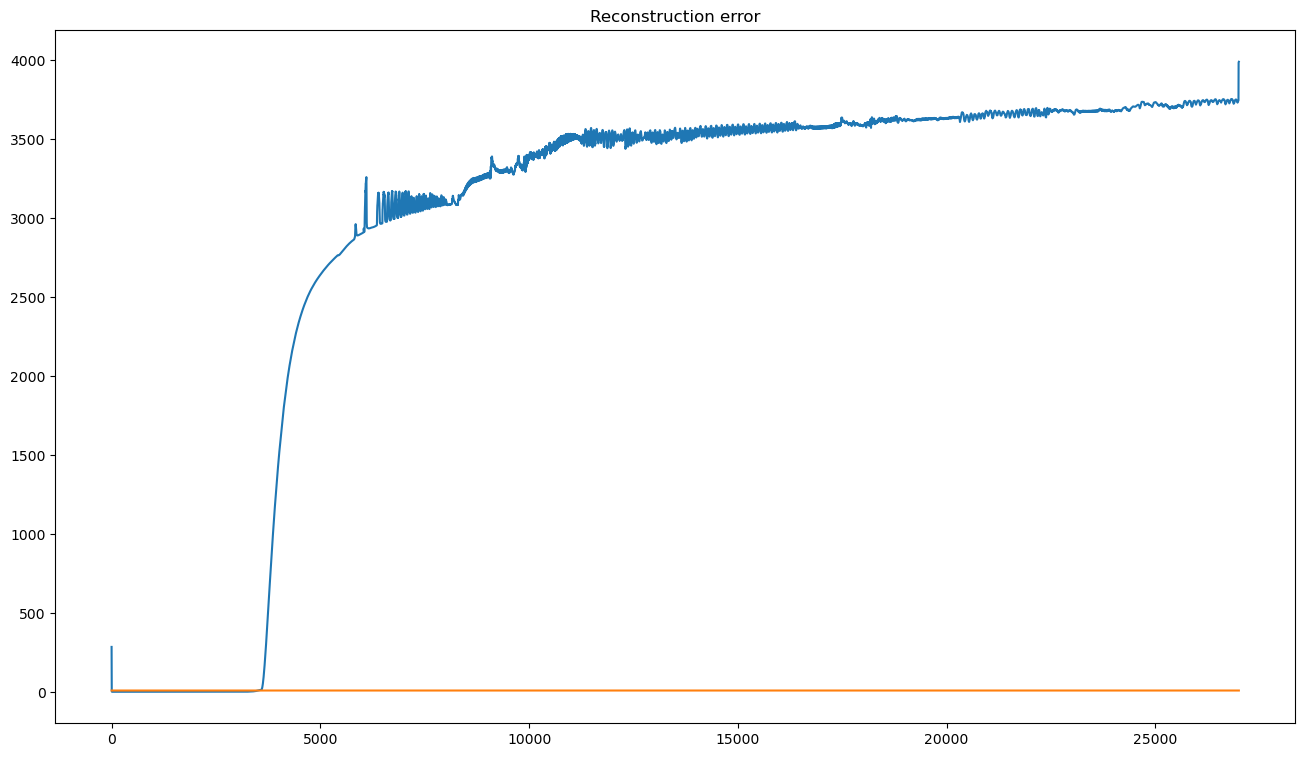

In [21]:
# q3 = np.percentile(r_e, 75)
# q1 = np.percentile(r_e, 25)
# iqr = q3 - q1

plt.figure(figsize=(16,9))
plt.plot(r_e)
plt.plot(np.full(r_e.shape[0], thres))
# xmin, xmax, ymin, ymax = plt.axis()
# plt.fill_betweenx(np.linspace(thres-iqr, thres+iqr, 100), r_e.shape[0], color='blue', alpha=0.3)
plt.title("Reconstruction error")

plt.show()

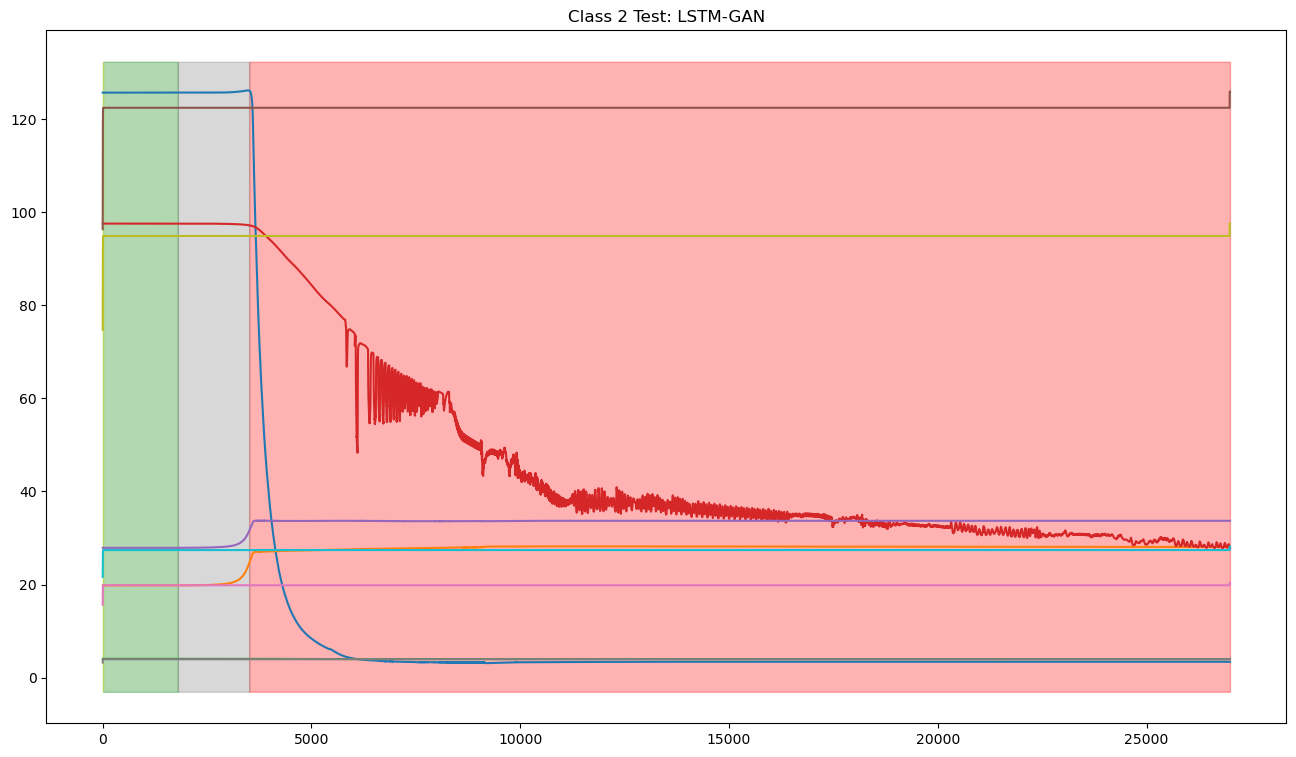

In [25]:
plt.figure(figsize=(16,9))
plt.plot(sample_test_np)
plt.plot(pred_2d)
xmin, xmax, ymin, ymax = plt.axis()
plt.fill_between(np.arange(0,len(pred_2d)), ymax, ymin, where=((~sample_test_class.astype(bool)) & (~sample_y_pred)), color='green', alpha=0.3)
plt.fill_between(np.arange(0,len(pred_2d)), ymax, ymin,where=((sample_test_class.astype(bool)) & (sample_y_pred)), color='red', alpha=0.3)
plt.fill_between(np.arange(0,len(pred_2d)), ymax, ymin,where=(~sample_test_class.astype(bool) & sample_y_pred ), color='yellow', alpha=0.3)
plt.fill_between(np.arange(0,len(pred_2d)), ymax, ymin,where=(sample_test_class.astype(bool) & ~sample_y_pred ), color='gray', alpha=0.3)
# plt.legend(['P-PDG','P-TPT', 'T-TPT','P-PDG_rec','P-TPT_rec', 'T-TPT_rec','normal','anomaly','missclasiffied (FP)','missclasiffied (FN)'])
plt.title("Class 2 Test: LSTM-GAN")
plt.show()

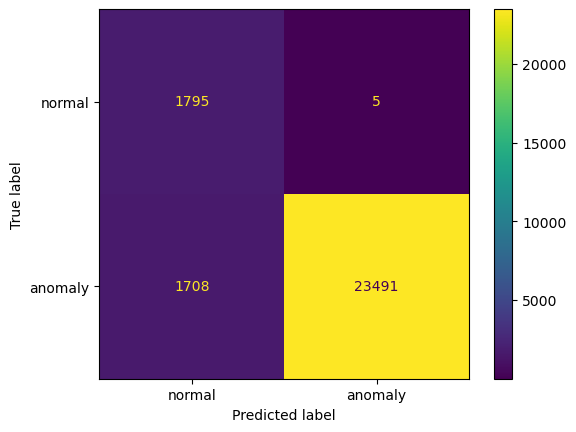

In [22]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(np.array(sample_test_class).astype(bool), sample_y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['normal', 'anomaly'])
cm_display.plot()

In [21]:
gener = keras.models.load_model("generator_lstm_gan_10.h5")

In [22]:
merged_df_test = get_dataset('dataset_processed/splitted/2/test')
merged_data_test_class = merged_df_test['class']

merged_data_test_np = merged_df_test.drop('class', axis=1).values

In [27]:
scaler_test = pickle.load(open('StandardScaler.pkl', 'rb'))
merged_data_test_np_scaled = scaler_test.transform(merged_data_test_np)
merged_data_test_np_3d = convert_time_window(merged_data_test_np, 10)

In [28]:
test_data = merged_data_test_np_3d
fake_data = gener.predict(test_data)


3439/3439 [==============================] - 15s 4ms/step


In [31]:
fake_data_2d = inverse_convert_time_window(fake_data)

In [41]:
scalerrr = sklearn.preprocessing.StandardScaler()
fake_data_2d_scaled = scalerrr.fit_transform(fake_data_2d)

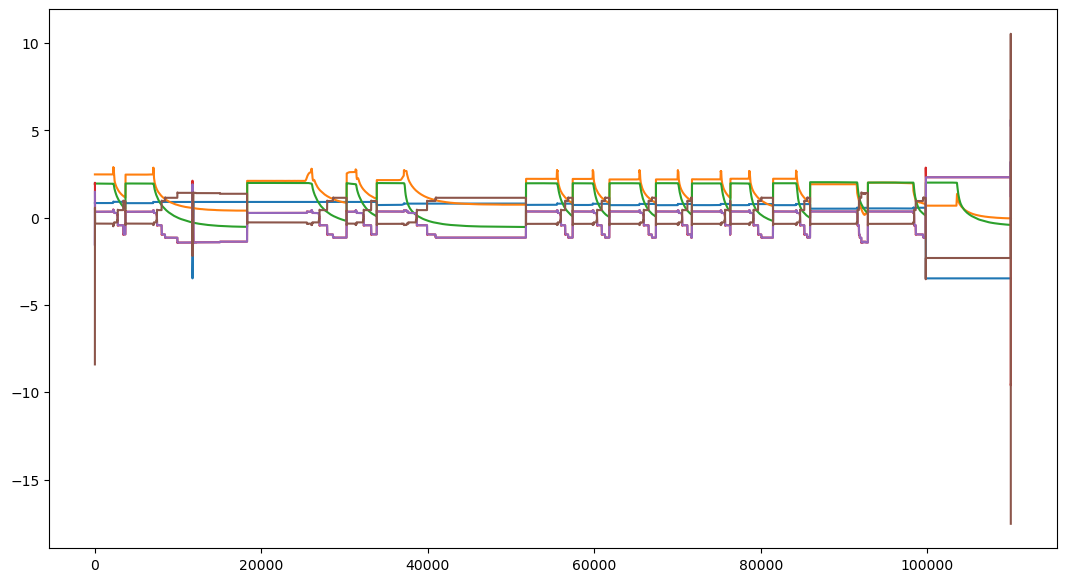

In [44]:
plt.figure(figsize=(13,7))
plt.plot(merged_data_test_np_scaled)
plt.plot(fake_data_2d_scaled)
plt.show()

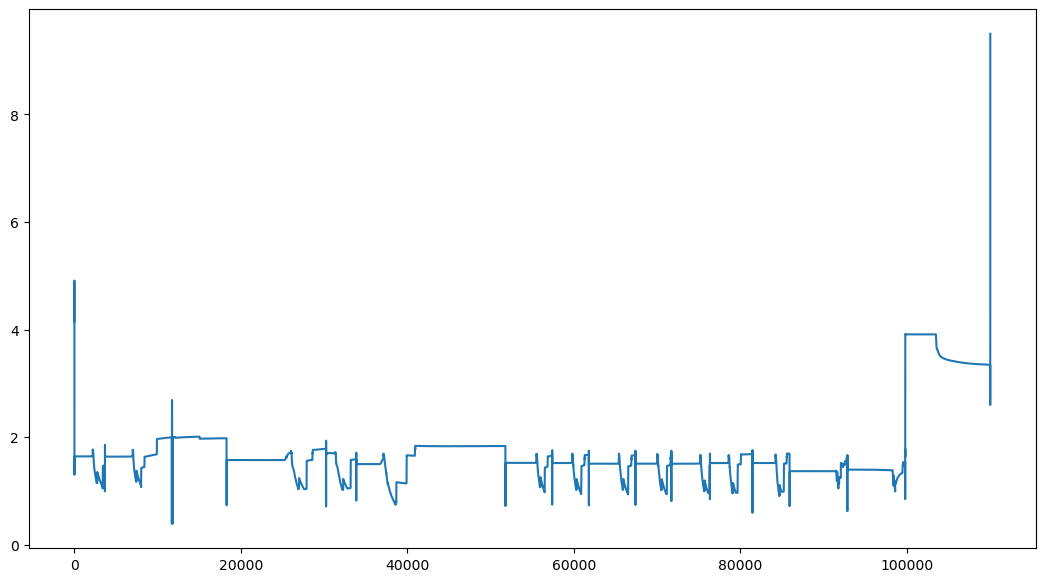

In [46]:
r_e = calculate_reconstruction_loss(merged_data_test_np_scaled, fake_data_2d_scaled)

plt.figure(figsize=(13,7))
plt.plot(r_e)
# plt.plot(fake_data_2d_scaled)
plt.show()

In [28]:

# Latent space reconstruction loss
latent_real = generator(test_data)
latent_fake = generator(fake_data)

anomaly_score = np.mean(np.square(latent_real - latent_fake), axis=1)


In [ ]:

# Evaluate the model (replace `true_labels` with actual labels)
true_labels = np.random.randint(0, 4, size=1000)
evaluate_model(train_data, true_labels, thresholds=[0.2, 0.5, 0.7])